In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [27]:

train_data=pd.read_csv(r"C:\Users\hp\Desktop\Ex.csv")
train_data.head()
#pd.options.display.max_colwidth = 500

,Insult,Date,Comment
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th..."
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ..."
2,1,20120618213617Z,"""Agree with Alan you are an extremest idiot. ..."
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou..."
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ..."


In [3]:
def loadBW():
    f = open('badwords.txt', "r")
    bwMap = dict()
    for line in f:
        sp = line.strip().lower().split(",")
        if len(sp) == 2:
            bwMap[sp[0].strip()] = sp[1].strip()
    return bwMap

In [28]:
def normalize(f):
    f = [x.lower() for x in f]
    f = [x.replace("\\n"," ") for x in f]        
    f = [x.replace("\\t"," ") for x in f]        
    f = [x.replace("\\xa0"," ") for x in f]
    f = [x.replace("\\xc2"," ") for x in f]
    f = [x.replace(" u "," you ") for x in f]
    f = [x.replace(" em "," them ") for x in f]
    f = [x.replace(" da "," the ") for x in f]
    f = [x.replace(" yo "," you ") for x in f]
    f = [x.replace(" ur "," you ") for x in f]    
    f = [x.replace("won't", "will not") for x in f]
    f = [x.replace("can't", "cannot") for x in f]
    f = [x.replace("i'm", "i am") for x in f]
    f = [x.replace(" im ", " i am ") for x in f]
    f = [x.replace("ain't", "is not") for x in f]
    f = [x.replace("'ll", " will") for x in f]
    f = [x.replace("'t", " not") for x in f]
    f = [x.replace("'ve", " have") for x in f]
    f = [x.replace("'s", " is") for x in f]
    f = [x.replace("'re", " are") for x in f]
    f = [x.replace("'d", " would") for x in f]
    bwMap = loadBW()
    for key, value in bwMap.items():
        kpad = "" + key + ""
        vpad = " " + value + " "

        
    return f

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
stop_words=stopwords.words('english')
stop_words.remove('you')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', '

In [30]:
def cleaning(x):
    train_data.columns
    tokenized_data=[]
    cleaned_data=[]
    for i in x:
        normalize(i)
        tokenized_data.append(nltk.word_tokenize(i.lower()))
    punct=[i for i in string.punctuation]
    noise=stop_words+punct+['``',"''"]   
    for i in tokenized_data:
        k=[j for j in i if j not in noise]
        cleaned_data.append(k)
    cleaned_data=[' '.join(x) for x in cleaned_data]
    return cleaned_data
#cleaning(train_data['Comment'])

In [8]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0, stop_words = 'english')
X_train=normalize(train_data['Comment'])
tfidf_matrix =  tf.fit_transform(X_train)
feature_names = tf.get_feature_names()

In [9]:
Y_train=train_data['Insult'].astype('int')
y=np.array(Y_train)

ch2 = SelectKBest(chi2, 500*3)
X_train = ch2.fit_transform(tfidf_matrix,y)
ch2_features = [feature_names[i] for i in ch2.get_support(indices=True)]
X_train_dense=X_train.toarray()
#X_test = ch2.transform(X_test)

In [10]:
glm=linear_model.LogisticRegression(C=3)
glm.fit(X_train_dense, y)
pred = glm.predict_proba(X_train_dense) 
preds=pred[:,1]

In [11]:
final_pred=[]
len(preds[preds>0.29])
for i in range(len(preds)):
    if preds[i]>=0.28:
        final_pred.append(1)
    else:
        final_pred.append(0)
#final_pred=np.asarray(final_pred)
#len(Y_train[Y_train==1])
#len(final_pred)

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_train,final_pred)
confusion_matrix

array([[1816,  138],
       [  47,  646]], dtype=int64)

In [13]:
# array([[2618,  280],
#       [ 276,  773]], dtype=int64)

# array([[2654,  244],
#       [ 303,  746]], dtype=int64)

# array([[2618,  280],
#       [ 274,  775]], dtype=int64)
(2634+964)/(len(final_pred))

1.35927465054779

In [14]:
test_data=pd.read_csv(r"C:\Users\hp\Desktop\test_with_solutions1.csv")
X_test=normalize(test_data['Comment'])
Y_actual=test_data['Insult'].astype('int')


X_test=cleaning(X_test)

In [15]:
X_test=tf.transform(X_test)

In [16]:
X_test=ch2.transform(X_test)
X_test_dense=X_test.toarray()

In [17]:
test_pred=glm.predict_proba(X_test_dense)

In [18]:
test_pred=test_pred[:,1]

In [19]:
final_test_pred=[]
for i in range(len(test_pred)):
    if test_pred[i]>=0.28:
        final_test_pred.append(1)
    else:
        final_test_pred.append(0)

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(Y_actual,final_test_pred)
confusion_matrix1
(1682+463)/len(final_test_pred)

0.8103513411409142

In [21]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Y_actual, final_test_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [22]:
roc_auc

{0: 0.9285666284130971}

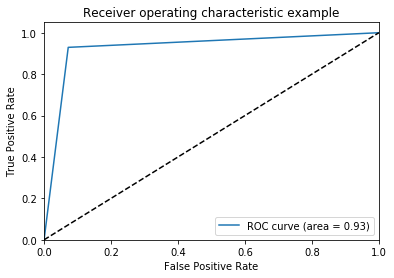

In [23]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr[0], tpr[0], label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
CRED = '\033[91m'
CEND = '\033[0m'
CGREEN = '\33[32m' 
new_comment=input("Enter Chat: ")
while(new_comment!='exit'):
    X_test=test_data['Comment']
    X_test.set_value(max(X_test.index) + 1,  str(new_comment)) 
    X_test.to_csv(r"C:\Users\hp\Desktop\X_test",header=['Comment'])
    X_test1=pd.read_csv(r"C:\Users\hp\Desktop\X_test.csv")
    X_test1=normalize(X_test1['Comment'])
    X_test1=tf.transform(X_test1)
    X_test1=ch2.transform(X_test1)
    X_test_dense1=X_test1.toarray()
    test_pred1=glm.predict_proba(X_test_dense1)
    test_pred1=test_pred1[:,1]
    final_test_pred1=[]
    for i in range(len(test_pred1)):
        if test_pred1[i]>=0.28:
            final_test_pred1.append(1)
        else:
            final_test_pred1.append(0)
    if test_pred1[-1]>=0.7:
        print(CRED+'Strong abusive content detected. You have been warned.'+CEND)
    if (0.3<=float(test_pred1[-1])<0.7):
        print(CRED+'Insult detected. Kindly mind your words.'+CEND)
    if test_pred1[-1]<=0.3:
        print(CGREEN+"Nicely said! Would like to hear more from you."+CEND)
    print(final_test_pred1[-1],test_pred1[-1])
    new_comment=input("\nEnter Chat: ")

Enter Chat: exit


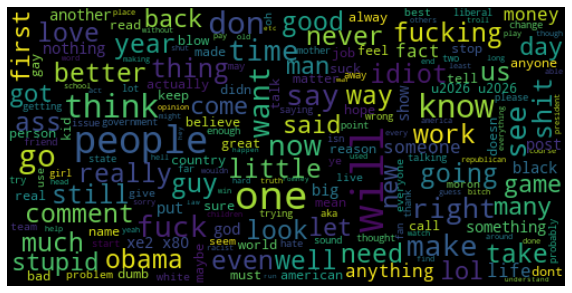

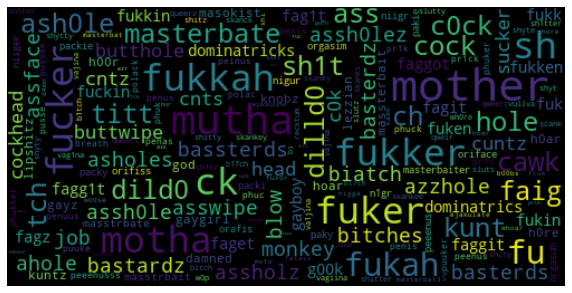

In [25]:
text=' '.join(i for i in normalize(train_data['Comment']))

wordcloud = WordCloud(max_font_size=40,width=500,height=250).generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Abusive Word Variants
bwmap=loadBW()
bwmap=' '.join(str(i) for i in bwmap)
wordcloud = WordCloud(max_font_size=40,width=500,height=250).generate(bwmap)
plt.figure(figsize=(10,10))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
import re
bwmap1=loadBW()
l=p=[]
for i in bwmap1.values():
    l.append(i)


cnt=tr=0
for i in normalize(train_data['Comment']):
    #print(i)
    tr+=1
    for j in list(set(l)):
        if re.search(j,i):
            cnt+=1
print(cnt,tr)
print((2250-1049)/2250)


wv_cnt=wv_tr=0
for i in train_data['Comment']:
    #print(i)
    wv_tr+=1
    for j in list(set(l)):
        #print(j)
        if re.search(j,i):
            wv_cnt+=1
print(wv_cnt,wv_tr)

1474 2647
0.5337777777777778
1265 2647
